# Build an Agentic Corrective RAG System with LangGraph

This project will cover a full hands-on workflow and demonstration of how to build an Agentic Corrective RAG (CRAG) System with LangGraph

The idea would be to implement the workflow taking inspiration from the [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884) research paper.

The main challenge of RAG systems include:

- Poor Retrieval can lead to issues in LLM response generation
- Bad retrieval or lack of information in the vector database can also lead to out of context or hallucinated answers

The idea is to couple a RAG system with a few checks in place and perform web searches if there is a lack of relevant context documents to the given user query.

We can build this as an agentic RAG system by having a specific functionality step as a node in the graph and use LangGraph to implement it. Key steps in the node will include prompts being sent to LLMs to perform specific tasks as seen in the detailed workflow below:

![](https://i.imgur.com/oAfXksw.png)


### Agentic Corrective RAG System Workflow

This project implements an **Agentic Corrective RAG System** that enhances the reliability and precision of responses by combining document grading, aumenting web search, and RAG. The system ensures only high-quality, grounded answers are generated even when the initial context retrieved from the vector database is incomplete or irrelevant.

The workflow includes the following components:

1. **Document Retrieval and Grading**:
   - A user query is first sent to a **Vector Database** to retrieve relevant documents.
   - These documents are passed through an **LLM Grader Prompt**:
     - The LLM evaluates each document and labels it as either **'yes'** (relevant) or **'no'** (irrelevant) based on its usefulness for answering the query.
     - This filtering step ensures that only the most relevant documents are retained for response generation.

2. **Dynamic Decision Routing**:
   - A **Decision Node** checks the document grading results:
     - If **> 50% of retrieved documents are relevant**, the system proceeds with a **standard RAG Prompt**, using only those documents to generate an answer.
     - If **<= 50% of retrieved documents are relevant**, the system switches to a **fallback corrective workflow**.

3. **Query Rephrasing and Web Search**:
   - When retrieved context is inadequate:
     - The original query is sent to the LLM with a **Rephrase Prompt** to generate a more search-optimized version of the query.
     - The rephrased query is passed to a **Web Search Tool** to retrieve fresh and more relevant context documents from the web.
     - These web-retrieved documents are then combined with any relevant retrieved context documents from the Vector DB and used as the final context documents

4. **Final Answer Generation**:
   - Whether using documents from the vector database or web search, the final step involves sending the query and relevant context documents into the **RAG Prompt**, which instructs the LLM to:
     - Use only the given documents to answer the question.
     - Avoid making up information or hallucinating unsupported content.

This agentic workflow adds an additional layer of control and recovery to the RAG pipeline, ensuring more accurate responses in dynamic and unpredictable retrieval scenarios.



___Created By: [Dipanjan (DJ)](https://www.linkedin.com/in/dipanjans/)___


## Install OpenAI, Tavily, LangGraph and LangChain dependencies


In [1]:
!pip install langchain==0.3.20
!pip install langchain-openai==0.3.9
!pip install langchain-community==0.3.20
!pip install langgraph==0.3.18
!pip install langchain-tavily==0.1.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.21
    Uninstalling langchain-0.3.21:
      Successfully uninstalled langchain-0.3.21
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 897.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.20
    Uninstalling langchain-0.3.20:
      Successfully uninstalled langchain-0.3.20
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 823.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Install PyMuPDF for loading PDF documents

In [2]:
!pip install pymupdf==1.25.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 16.5 MB/s eta 0:00:00


## Install ChromaDB LangChain Wrapper for Vector DB

In [3]:
!pip install langchain-chroma==0.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.1 MB/s eta 0:00

## Enter Open AI API Key

In [4]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [5]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [6]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Build a Search Index for Research Paper Data

We will build a vector database for retrieval and search by indexing a few research paper documents, similar to any standard RAG workflows

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [7]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Get the research paper data

In [8]:
# if you can't download using the following code
# go to https://drive.google.com/file/d/1ZOtPmuR-2KpzPvkiQiTVxAyJFo6NszG-/view?usp=sharing download it
# manually upload it on colab

!gdown 1ZOtPmuR-2KpzPvkiQiTVxAyJFo6NszG-

Downloading...
From: https://drive.google.com/uc?id=1ZOtPmuR-2KpzPvkiQiTVxAyJFo6NszG-
To: /content/research_papers.zip
100% 19.3M/19.3M [00:00<00:00, 78.6MB/s]


In [9]:
!unzip research_papers.zip

Archive:  research_papers.zip
   creating: research_papers/
  inflating: research_papers/attention.pdf  
  inflating: research_papers/chain_of_thought.pdf  
  inflating: research_papers/diffusion.pdf  
  inflating: research_papers/dino.pdf  
  inflating: research_papers/peft.pdf  


### Load and Chunk Documents

We create a directory loader to use a PDF loader (using pymupdf) and load all PDF documents from a given folder

In [10]:
from langchain_community.document_loaders import DirectoryLoader

# Define a function to create a DirectoryLoader for a specific file type
def create_directory_loader(file_type, directory_path, loader_class, loader_args):
    return DirectoryLoader(
        path=directory_path,
        glob=f"**/*{file_type}",
        loader_cls=loader_class,
        loader_kwargs=loader_args,
        show_progress=True
    )

In [11]:
from langchain_community.document_loaders import PyMuPDFLoader

pdf_extn = '.pdf'
pdf_loader_class = PyMuPDFLoader
pdf_loader_args = {} # in case you want to change any settings in pymupdfloader
directory= './research_papers'

pdf_loader = create_directory_loader(file_type=pdf_extn,
                                     directory_path=directory,
                                     loader_class=pdf_loader_class,
                                     loader_args=pdf_loader_args)

# load docs
docs = pdf_loader.load()
len(docs) # PyMuPDF loads every document and breaks it per page by default

100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


62

In [12]:
docs[0]

Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20250321115848', 'source': 'research_papers/dino.pdf', 'file_path': 'research_papers/dino.pdf', 'total_pages': 10, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': 'D:20250321115848', 'page': 0}, page_content='Emerging Properties in Self-Supervised Vision Transformers\nMathilde Caron1,2\nHugo Touvron1,3\nIshan Misra1\nHerv´e Jegou1\nJulien Mairal2\nPiotr Bojanowski1\nArmand Joulin1\n1 Facebook AI Research\n2 Inria∗\n3 Sorbonne University\nFigure 1: Self-attention from a Vision Transformer with 8 × 8 patches trained with no supervision. We look at the self-attention of\nthe [CLS] token on the heads of the last layer. This token is not attached to any label nor supervision. These maps show that the model\nautomatically learns class-speciﬁc features leading to unsupervised object segmentations.\nAbstract\nIn this paper,

We then use standard recursive character text chunking

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [14]:
len(chunked_docs)

100

In [15]:
chunked_docs[:3]

[Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20250321115848', 'source': 'research_papers/dino.pdf', 'file_path': 'research_papers/dino.pdf', 'total_pages': 10, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': 'D:20250321115848', 'page': 0}, page_content='Emerging Properties in Self-Supervised Vision Transformers\nMathilde Caron1,2\nHugo Touvron1,3\nIshan Misra1\nHerv´e Jegou1\nJulien Mairal2\nPiotr Bojanowski1\nArmand Joulin1\n1 Facebook AI Research\n2 Inria∗\n3 Sorbonne University\nFigure 1: Self-attention from a Vision Transformer with 8 × 8 patches trained with no supervision. We look at the self-attention of\nthe [CLS] token on the heads of the last layer. This token is not attached to any label nor supervision. These maps show that the model\nautomatically learns class-speciﬁc features leading to unsupervised object segmentations.\nAbstract\nIn this paper

### Create a Vector DB and persist on disk

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [16]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='rag_db',
                                  embedding=openai_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./rag_db")

### Setup a Vector Database Retriever

Here we use the following retrieval strategy:

- Similarity with Threshold Retrieval


### Similarity with Threshold Retrieval

We use cosine similarity here and retrieve the top 5 similar documents based on the user input query and also introduce a cutoff to not return any documents which are below a certain similarity threshold

In [17]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 5,
                                                                       "score_threshold": 0.35})

### Test out a few queries

In [18]:
query = "what is PEFT?"
topk_docs = similarity_threshold_retriever.invoke(query)
topk_docs

[Document(id='8449623b-7b02-4119-b3db-2c554f136b4a', metadata={'author': '', 'creationDate': 'D:20250321120420', 'creationdate': 'D:20250321120420', 'creator': 'PDFium', 'file_path': 'research_papers/peft.pdf', 'format': 'PDF 1.7', 'keywords': '', 'modDate': '', 'moddate': '', 'page': 0, 'producer': 'PDFium', 'source': 'research_papers/peft.pdf', 'subject': '', 'title': '', 'total_pages': 20, 'trapped': ''}, page_content='keeping the rest unaltered. Furthermore, the application of\nPEFT extends beyond the realm of NLP and quickly attracts\ninterest in the CV community for handling fine-tuning vision\nmodels with large parameters, such as Vision Transformers\n(ViT) and diffusion models, as well as disciplinary models\nsuch as vision-language models.\nIn this survey, we systematically review and categorize\nrecent advancements in PEFT algorithms as well as the system\nimplementation costs associated with various PEFT algorithms\nacross diverse scenarios. Figure 1 presents the overview co

Looks like it is getting relevant documents from the vector DB

In [20]:
query = "what is time series forecasting?"
topk_docs = similarity_threshold_retriever.invoke(query)
topk_docs

[]

Whoops seems like there exists no relevant docs for this. The Agentic Corrective RAG should still be able to handle queries like this

In [21]:
query = "what are popular patterns for Agentic AI?"
topk_docs = similarity_threshold_retriever.invoke(query)
topk_docs

[Document(id='653b23c6-1221-462c-b6be-caa1b84ceb8c', metadata={'author': '', 'creationDate': 'D:20250321115731', 'creationdate': 'D:20250321115731', 'creator': 'PDFium', 'file_path': 'research_papers/attention.pdf', 'format': 'PDF 1.7', 'keywords': '', 'modDate': '', 'moddate': '', 'page': 1, 'producer': 'PDFium', 'source': 'research_papers/attention.pdf', 'subject': '', 'title': '', 'total_pages': 10, 'trapped': ''}, page_content='self-attention and discuss its advantages over models such as [17, 18] and [9].\n3\nModel Architecture\nMost competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].\nHere, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence\nof continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output\nsequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive\n[10], consuming the previously generated symbols as additional input

None of the above documents are relevant to the query. The Agentic Corrective RAG System should be able to handle this also

## Create AI Workflows and Tools for Key Components in our Agentic RAG System

There are a few AI workflows (sequential pipelines) and tools we would need to create which we will be using in different steps in our Agentic Corrective RAG workflow. These include:

- **Query Retrieval Grader Workflow:** This is an essential workflow which can take in a user query, a list of retrieved documents from the vector DB and grade each query as 'yes' or 'no' based on if the document is relevant to the user query or not

- **QA RAG Workflow:** This is a workflow which can take in a user query, list of retrived context documents and use a standard RAG workflow where an LLM uses these context documents to generate a contextual response for the user query

- **Query Rephraser Workflow:** This is a workflow which uses an LLM to rephrase the given user query (if needed) and make it more optimized for web search

- **Web Search Tool:** Build a custom tool which uses the Tavily Search API to search for a user query, get the top web page results and also extract the text content from those web pages

Most of these workflows will be built as LangChain chains (pipelines)

### Create a Query Retrieval Grader Workflow

Here we will use an LLM itself to grade if any retrieved document is relevant to the given user query - Answer will be either `yes` or `no` for each document

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - The overall grade should focus more on the semantic meaning rather than just individual words.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [23]:
query = "What is PEFT?"
topk_docs = similarity_threshold_retriever.invoke(query)
for doc in topk_docs:
    print(doc.page_content[:200])
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

keeping the rest unaltered. Furthermore, the application of
PEFT extends beyond the realm of NLP and quickly attracts
interest in the CV community for handling fine-tuning vision
models with large par
GRADE: binary_score='yes'

mark for PEFT is still lacking. This gap hinders the ability
to fairly compare the performance and efficiency of different
PEFT approaches. A well-accepted, up-to-date benchmark
akin to MMDetection [2
GRADE: binary_score='no'

17
LLMs
Edge 
Device 
Personal data
Cloud
Trainable 
Modules
🔥
Frozen Large Models
Scheduler
Request Pool
Query
Response
Execution
Engine
Serving System
I like
I enjoy
LLM
programming
(a)
(b)
Fig. 10:
GRADE: binary_score='yes'

content. To overcome this, IP-Adapter introduces a novel
decoupled cross-attention mechanism to distinguish between
text and image features. IP-Adapter adds an additional cross-
attention layer exclus
GRADE: binary_score='yes'

19
The second challenge is beyond the computational cost,
designing an efficient system a

In [24]:
query = "what is chain of thought prompting?"
topk_docs = similarity_threshold_retriever.invoke(query)
for doc in topk_docs:
    print(doc.page_content[:200])
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

the patterns underlying inputs and outputs via a large training dataset).
2
Chain-of-Thought Prompting
Consider one’s own thought process when solving a complicated reasoning task such as a multi-step
GRADE: binary_score='yes'

1
Introduction
Math Word Problems (GSM8K)
0
20
40
60
80
100
33
55
18
57
Solve rate (%)
Finetuned GPT-3 175B
Prior best
PaLM 540B: standard prompting
PaLM 540B: chain-of-thought prompting
Figure 2:
PaL
GRADE: binary_score='yes'

et al., 2022). Whereas these approaches improve or augment the input part of the prompt (e.g.,
instructions that are prepended to inputs), our work takes the orthogonal direction of augmenting the
out
GRADE: binary_score='yes'

Chain-of-Thought Prompting Elicits Reasoning
in Large Language Models
Jason Wei
Xuezhi Wang
Dale Schuurmans
Maarten Bosma
Brian Ichter
Fei Xia
Ed H. Chi
Quoc V. Le
Denny Zhou
Google Research, Brain Te
GRADE: binary_score='yes'

experiments on commonsense reasoning underscored how the linguistic nature of chain-of-t

In [25]:
query = "what are popular patterns for Agentic AI"
topk_docs = similarity_threshold_retriever.invoke(query)
for doc in topk_docs:
    print(doc.page_content[:200])
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

self-attention and discuss its advantages over models such as [17, 18] and [9].
3
Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].

GRADE: binary_score='no'

20
G. PEFT with model compression
Model compression is one of the most effective ways to
make LLM executable on resource-limited devices. Yet, the
impact of model compression techniques on the perform
GRADE: binary_score='no'

in the OpenAI API). We sample from the models via greedy decoding (though follow-up work shows
chain-of-thought prompting can be improved by taking the majority ﬁnal answer over many sampled
generatio
GRADE: binary_score='no'



In [26]:
query = "Explain self-attention in detail"
topk_docs = similarity_threshold_retriever.invoke(query)
for doc in topk_docs:
    print(doc.page_content[:200])
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations
for different layer types. n is the sequence length, d is the representation dimension, k is the kernel

GRADE: binary_score='yes'

Scaled Dot-Product Attention
Multi-Head Attention
Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several
attention layers running in parallel.
of the values, w
GRADE: binary_score='yes'

Emerging Properties in Self-Supervised Vision Transformers
Mathilde Caron1,2
Hugo Touvron1,3
Ishan Misra1
Herv´e Jegou1
Julien Mairal2
Piotr Bojanowski1
Armand Joulin1
1 Facebook AI Research
2 Inria∗

GRADE: binary_score='no'

7
V
K
Q
⊙
lk
lv
lff
⊙
softmax
Wdown
𝛔
⊙
Wup
(a) (IA)3
⊙
⊕
Operation 1
Operation 2
(b) SSF
scale
shift
Fig. 6: Illustration of (IA)3 and SSF. Blue represents frozen,
while yellow represents trainable.

GRADE: binary_score='no'

1
Introduction
Recurrent neural networks, long short-term memory [13] and gated recurrent 

### Create a QA RAG Workflow

This can take in a user query, list of retrived context documents and use a standard RAG workflow where an LLM uses these context documents to generate a contextual response for the user query

In [27]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks on popular research topics.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)
# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [28]:
query = "what is chain of thought prompting?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

Chain-of-thought prompting is a method used to enhance the reasoning capabilities of large language models by providing them with a series of intermediate reasoning steps that lead to the final answer of a problem. This approach is inspired by the way humans solve complex reasoning tasks, such as multi-step math word problems, by breaking them down into smaller, manageable steps and solving each one sequentially before arriving at the final solution.

In the context of language models, chain-of-thought prompting involves presenting the model with a prompt that includes examples of input, a chain of thought (the intermediate reasoning steps), and the output (the final answer). This method has been shown to significantly improve the performance of language models on tasks that require complex reasoning, such as arithmetic, commonsense, and symbolic reasoning tasks.

The effectiveness of chain-of-thought prompting is particularly evident in large language models, where it can lead to subs

In [29]:
query = "Explain self-attention in detail"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

Self-attention is a mechanism used in neural networks, particularly in the context of sequence modeling and transduction tasks, such as language translation. It allows the model to weigh the importance of different elements in a sequence when computing a representation for each element. Here's a detailed explanation of how self-attention works and its advantages:

### Self-Attention Mechanism

1. **Input Representation**: In self-attention, each element of the input sequence is represented as a vector. These vectors are typically derived from embeddings of the input tokens.

2. **Queries, Keys, and Values**: For each element in the sequence, self-attention computes three vectors: a query vector, a key vector, and a value vector. These vectors are obtained by multiplying the input vector by learned weight matrices.

3. **Scaled Dot-Product Attention**: The core of self-attention is the scaled dot-product attention mechanism. It involves the following steps:
   - Compute the dot product 

In [30]:
query = "What are the most popular design patterns for Agentic AI?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

I don't know the answer. The provided context does not contain information about the most popular design patterns for Agentic AI.


In [31]:
query = "what is time-series forecasting?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

I don't know the answer.


### Create a Query Rephraser Workflow

This uses an LLM to rephrase the given user query (if needed) and make it more optimized for web search

In [32]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - Before re-writing, look at the input question and try to reason about the underlying semantic intent / meaning and then re-write it.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)
# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [33]:
query = "what are popular patterns for Agentic AI?"
question_rewriter.invoke({"question": query})

'What are the most popular design patterns for Agentic AI systems?'

### Create a Web Search Tool

Here we will be using the [Tavily API](https://tavily.com/#api) for our web searches to search and extract content from web pages in the top search results.

In [34]:
from langchain_tavily._utilities import TavilySearchAPIWrapper
from langchain_core.tools import tool

tavily_search = TavilySearchAPIWrapper()

@tool
def search_web(query: str) -> list:
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=6,
                                        search_depth='advanced',
                                        include_answer=False,
                                        include_raw_content=True)
    results = [r['raw_content'] for r in results['results']]
    results = [doc for doc in results if doc is not None] # remove blank page content
    return results

## Define the Agent State Schema

Here we define the key state schema that maintains the agent's state across different steps of execution in the LangGraph workflow.

We define a `GraphState` typed dictionary to track relevant information during the execution of the Agentic Corrective RAG System:

- **question**: The query asked by the user.
- **generation**: The final response generated by the LLM, based on retrieved context documents and / or web search.
- **web_search_needed**: A flag (`yes` or `no`) indicating whether a web search fallback is required due to insufficient or irrelevant context from the vector database.
- **documents**: A list of context documents used to answer the query. These may be retrieved from either the internal vector database and (or) a web search tool depending on the workflow path.


In [35]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

## Plan the Agent Workflow Structure

This is the Agent workflow we will be using

![](https://i.imgur.com/xKC0o1A.png)

Next up we will define python functions for each of the nodes in this Agent graph

## Create Node Functions

Each function below represents a stage in processing a user query in the Agentic Corrective RAG System:

1. **retrieve**: Retrieves a set of potentially relevant documents from a vector database based on the user's original query.

2. **grade_documents**: Uses an LLM-based grading to evaluate whether each retrieved document is relevant to the query. Also sets the `web_search_needed` flag variable.
  - Computes the %age of relevant context documents.
  - If this is > a threshold (0.5 is our case) then `web_search_needed=No`
  - However if this %age of relevant documents is <= the threshold (0.5 in our case) or no documents were retrieved for the query then `web_search_needed=Yes`

3. **rewrite_query**: This function rephrases the original query into a version that is better optimized for web search. This ensures better recall during the fallback web search step.

4. **web_search**: Performs a web search using the rephrased query and collects external context documents for RAG response generation.

5. **generate_answer**: Takes the query and the most relevant set of context documents — whether from the vector DB and / or the web — and generates a grounded, final response using a constrained RAG prompt.


### Create the retrieve function

Retrieves a set of potentially relevant documents from a vector database based on the user's original query.

In [48]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents}

### Create the grade_documents function

Uses an LLM-based grading to evaluate whether each retrieved document is relevant to the query. Also sets the `web_search_needed` flag variable.
  - Computes the %age of relevant context documents.
  - If this is > a threshold (0.5 is our case) then `web_search_needed=No`
  - However if this %age of relevant documents is <= the threshold (0.5 in our case) or no documents were retrieved for the query then `web_search_needed=Yes`

In [49]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If <= 50% documents are relevant to question or documents are empty - Web Search needs to be done
    If > 50% documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    RELEVANCE_THRESHOLD = 0.5 # what %age of retrieved documents should at least be relevant

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    total_irrelevant = 0
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d) # store only relevant documents
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                total_irrelevant += 1 # count number of irrelevant documents

        relevance_frac = 1 - (total_irrelevant / len(documents)) # compute %age of relevant documents
        if relevance_frac <= RELEVANCE_THRESHOLD:
            print("---SEVERAL DOCUMENTS ("+str((1-relevance_frac)*100)+"%) ARE NOT RELEVANT TO QUESTION - WEB SEARCH NEEDED---")
            web_search_needed = "Yes"
        else:
            print("---MOST DOCUMENTS ("+str(relevance_frac*100)+"%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---")

    else:
        print("---NO DOCUMENTS RETRIEVED - WEB SEARCH NEEDED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "web_search_needed": web_search_needed}

### Create the rewrite_query function

This function rephrases the original query into a version that is better optimized for web search. This ensures better recall during the fallback web search step.

In [50]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("---REWRITE QUERY---")
    question = state["question"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}

### Create the web_search function

Performs a web search using the rephrased query and collects external context documents for RAG response generation.

In [51]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search and extract content from top search results
    docs = search_web.invoke(question)
    web_results = [Document(page_content=d) for d in docs]
    documents.extend(web_results)

    return {"documents": documents}

### Create the generate_answer function

Takes the query and the most relevant set of context documents — whether from the vector DB and / or the web — and generates a grounded, final response using a constrained RAG prompt.

In [52]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}

## Build and Compile the Agent Graph Workflow

We construct a LangGraph agent workflow with the following sequence of nodes:

1. **retrieve** → Retrieves documents from a vector database based on the user’s original query.
2. **grade_documents** → Uses an LLM grader to assess whether the retrieved documents are relevant to the query.
3. If **> 50% documents are relevant**, proceed directly to **generate_answer**.
4. If **<= 50% documents are relevant**, route the flow through a corrective fallback:
   - **rewrite_query** → Rephrases the original query to improve information retrieval from the web.
   - **web_search** → Performs a web search using the rephrased query and collects updated context.
5. Finally, **generate_answer** → Uses the best available context (from DB or web) to produce a grounded and accurate response.


In [53]:
from langgraph.graph import END, StateGraph

# Create a typed LangGraph state graph using the custom GraphState
agentic_rag = StateGraph(GraphState)

# Register each functional node in the graph that represents a step in the agent workflow
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Define the router function that directs the flow based on web_search_needed flag status
def generate_or_search(state):
    """
    Determines whether to generate an answer, or re-generate a question for web search.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # web search needed as some documents are not relevant
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"


# Define the flow of transitions between the nodes in the graph

# starting point is to retrieve documents from the vector db
agentic_rag.set_entry_point("retrieve")
# grade documents after that
agentic_rag.add_edge("retrieve", "grade_documents")
# either generate RAG response or go towards rewrite query for web search
agentic_rag.add_conditional_edges(
    "grade_documents",
    generate_or_search,
    ["rewrite_query", "generate_answer"]
)
# web search after rewriting query
agentic_rag.add_edge("rewrite_query", "web_search")
# generate answer after web search
agentic_rag.add_edge("web_search", "generate_answer")
# stop agent after generating answer
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

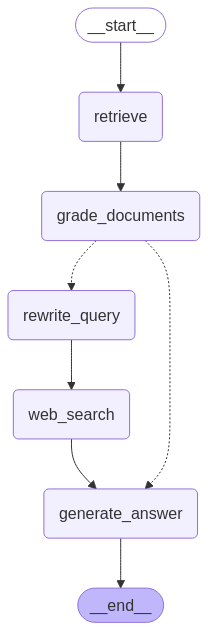

In [54]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

## Test the Agentic CRAG System

In [55]:
query = "what is chain of thought prompting?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---MOST DOCUMENTS (100.0%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [56]:
display(Markdown(response['generation']))

Chain-of-thought prompting is a method used to enhance the reasoning capabilities of large language models by providing them with a series of intermediate reasoning steps that lead to the final answer of a problem. This approach is inspired by the way humans solve complex reasoning tasks, such as multi-step math word problems, by breaking them down into smaller, manageable steps and solving each one sequentially.

In practice, chain-of-thought prompting involves presenting the language model with a prompt that includes examples of input-output pairs, where the output is not just the final answer but also includes a detailed explanation of the reasoning process. This is done by providing a few exemplars that demonstrate the task, which helps the model understand how to approach similar problems.

The method has been shown to significantly improve the performance of language models on a variety of reasoning tasks, including arithmetic, commonsense, and symbolic reasoning. For instance, experiments have demonstrated that chain-of-thought prompting can lead to state-of-the-art performance on benchmarks like the GSM8K math word problems, outperforming standard prompting techniques.

One of the key advantages of chain-of-thought prompting is that it does not require extensive training datasets or fine-tuning of the model. Instead, it leverages the model's existing capabilities by providing it with a few examples that illustrate the reasoning process. This makes it a cost-effective and efficient way to enhance the reasoning abilities of large language models. However, it is important to note that while this method emulates human-like reasoning processes, it does not necessarily mean that the model is truly "reasoning" in the human sense. Additionally, the effectiveness of chain-of-thought prompting tends to emerge only at larger model scales, which can be costly to implement in real-world applications.

In [57]:
response

{'question': 'what is chain of thought prompting?',
 'generation': 'Chain-of-thought prompting is a method used to enhance the reasoning capabilities of large language models by providing them with a series of intermediate reasoning steps that lead to the final answer of a problem. This approach is inspired by the way humans solve complex reasoning tasks, such as multi-step math word problems, by breaking them down into smaller, manageable steps and solving each one sequentially.\n\nIn practice, chain-of-thought prompting involves presenting the language model with a prompt that includes examples of input-output pairs, where the output is not just the final answer but also includes a detailed explanation of the reasoning process. This is done by providing a few exemplars that demonstrate the task, which helps the model understand how to approach similar problems.\n\nThe method has been shown to significantly improve the performance of language models on a variety of reasoning tasks, in

In [58]:
query = "What are the most popular design patterns for Agentic AI?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---SEVERAL DOCUMENTS (100.0%) ARE NOT RELEVANT TO QUESTION - WEB SEARCH NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [59]:
display(Markdown(response['generation']))

The top design patterns commonly used in Agentic AI development are:

1. **Reflection Pattern**: This pattern enhances an AI's ability to evaluate and refine its own outputs. It involves the AI reviewing its generated content or code as if it were a human reviewer, identifying errors, gaps, or areas that need improvement, and then offering suggestions for improvement. This iterative self-critique loop can be repeated multiple times to achieve a refined, polished result. It is particularly useful in tasks requiring precision, such as content creation, problem-solving, or code generation.

2. **Tool Use Pattern**: This pattern broadens an AI's capability by allowing it to interact with external tools and resources to enhance its problem-solving abilities. Instead of relying solely on internal computations or knowledge, an AI following this pattern can access databases, search the web, or execute complex functions via programming languages like Python. This enables AI systems to tackle more complex, multifaceted tasks where internal knowledge alone isn’t sufficient.

3. **Planning Pattern**: This pattern enables an AI to break down large, complicated tasks into smaller, more manageable components. It involves creating a roadmap of subtasks and determining the most efficient path to completion. Variations like ReAct (Reasoning and Acting) and ReWOO (Reasoning With Open Ontology) further extend this approach by integrating decision-making and contextual reasoning into the planning process, allowing for more adaptive and flexible planning.

4. **Multi-Agent Pattern**: This pattern involves assigning different agents (instances of an AI model with specific roles or functions) to handle various subtasks. These agents can work independently on their assignments while also communicating and collaborating to achieve a unified outcome. This pattern is particularly powerful for tackling large-scale or complex problems that require diverse skill sets.

These design patterns push the boundaries of what AI can do by encouraging self-evaluation, tool integration, strategic thinking, and collaboration, making AI systems more autonomous and capable.

In [60]:
query = "Explain self-attention in detail"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---MOST DOCUMENTS (60.0%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [61]:
display(Markdown(response['generation']))

Self-attention is a mechanism used in neural networks, particularly in models like the Transformer, to compute a representation of a sequence by relating different positions within the same sequence. It allows the model to weigh the importance of different elements in the sequence when computing the representation of each element, enabling the model to capture dependencies regardless of their distance in the sequence.

### Key Components of Self-Attention:

1. **Input Representation**:
   - The input to a self-attention mechanism consists of queries, keys, and values, which are derived from the input sequence. Each element in the sequence is transformed into these three components.

2. **Scaled Dot-Product Attention**:
   - The core operation in self-attention is the scaled dot-product attention. It involves computing the dot product of the query with all keys, scaling the result by the square root of the dimension of the keys (to prevent large dot products that could push the softmax function into regions with small gradients), and applying a softmax function to obtain attention weights. These weights are then used to compute a weighted sum of the values, producing the output of the attention mechanism.

   \[
   \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
   \]

   Here, \(Q\), \(K\), and \(V\) are matrices of queries, keys, and values, respectively, and \(d_k\) is the dimension of the keys.

3. **Multi-Head Attention**:
   - Instead of performing a single attention function, multi-head attention projects the queries, keys, and values into multiple subspaces and performs attention in parallel. This allows the model to jointly attend to information from different representation subspaces at different positions.

   - The outputs from each attention head are concatenated and linearly transformed to produce the final output.

4. **Positional Encoding**:
   - Since self-attention does not inherently capture the order of the sequence, positional encodings are added to the input embeddings to provide information about the position of each element in the sequence. These encodings can be fixed (e.g., using sine and cosine functions) or learned.

### Advantages of Self-Attention:

- **Parallelization**: Unlike recurrent layers, which process sequences sequentially, self-attention allows for parallelization across sequence positions, significantly speeding up computation, especially for long sequences.

- **Long-Range Dependencies**: Self-attention can capture dependencies between distant positions in the sequence with a constant number of operations, making it more effective at learning long-range dependencies compared to recurrent or convolutional layers.

- **Flexibility**: Self-attention is versatile and has been successfully applied to various tasks, including reading comprehension, summarization, and translation, without the need for recurrence or convolution.

In summary, self-attention is a powerful mechanism that enhances the ability of models to process sequences by focusing on relevant parts of the input, enabling efficient computation and effective learning of complex dependencies.

In [62]:
query = "what is time series forecasting?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---NO DOCUMENTS RETRIEVED - WEB SEARCH NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [63]:
display(Markdown(response['generation']))

Time series forecasting is a statistical technique used to predict future values based on historical time-stamped data. It involves analyzing patterns and trends in past data points collected over time to develop a model that can predict those patterns in the future. This method is crucial for making data-driven decisions across various fields, including finance, retail, healthcare, and more.

In time series forecasting, the data is typically decomposed into several components: trends, seasonality, cycles, and irregularities (or noise). Trends represent long-term movements in data, seasonality refers to regular patterns that occur at specific intervals, cycles are longer-term fluctuations, and irregularities are random variations that cannot be attributed to the other components.

The process of time series forecasting involves several steps, including data collection, preprocessing (such as handling missing values and outliers), model selection, and evaluation. Common models used in time series forecasting include ARIMA (AutoRegressive Integrated Moving Average), exponential smoothing, and neural networks like Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks.

Time series forecasting is widely used in various applications, such as predicting stock prices, sales forecasting, weather forecasting, and resource allocation. It helps organizations anticipate future trends, optimize resources, and make informed strategic decisions. However, it is important to note that time series forecasting is not infallible and is subject to limitations, such as handling non-stationary data, managing complex seasonality, and adapting to unexpected events. Therefore, it requires careful consideration of data quality, model selection, and evaluation to ensure accurate and reliable forecasts.